In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import random

# Data Preprocessing
#### load data

In [2]:
from datasets import load_dataset

ds = load_dataset("sentence-transformers/parallel-sentences-europarl", "en-es")

print(ds)
print(ds['train'][0])
dataset = ds['train']

d:\Personal\code\ML comp\New folder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['english', 'non_english'],
        num_rows: 1966848
    })
})
{'english': 'Resumption of the session', 'non_english': 'Reanudación del período de sesiones'}


In [ ]:
subset = dataset.shuffle(seed=42).select(range(40000))           # take only a sample
subset = subset.to_pandas()
subset.head()

,english,non_english
0,According to the United Nations Food and Agric...,Según la Organización de las Naciones Unidas p...
1,"Once again, we see the conflict between indust...",Una vez más vemos surgir el conflicto entre la...
2,All that has allowed us to understand one anot...,Todo esto ha hecho posible que nos conozcamos ...
3,The EU uses those expectations to demand refor...,La Unión Europea utiliza estas expectativas pa...
4,The relevant paragraphs have been amended and ...,Se han modificado los párrafos pertinentes y y...


In [ ]:
esp = subset['non_english'].to_list()
esp_sizes = [len(i.split()) for i in esp]                 # get no no. of words for each sentences
eng = subset['english'].to_list()
eng_sizes = [len(i.split()) for i in eng]

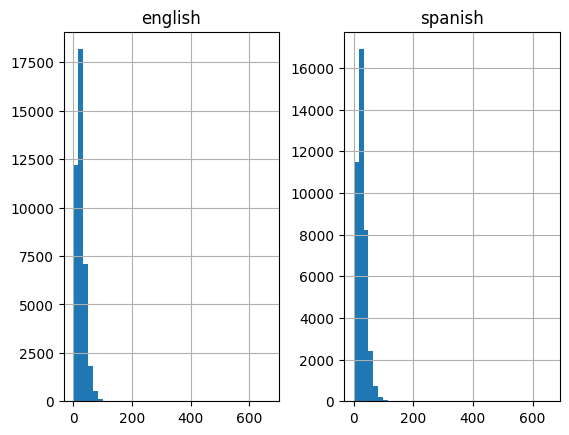

<Figure size 1200x800 with 0 Axes>

In [5]:
length_df = pd.DataFrame({'english':eng_sizes, 'spanish':esp_sizes})
length_df.hist(bins = 40)
plt.figure(figsize = (12,8))
plt.show()

In [ ]:
percentile_95 = length_df.quantile(0.95)                # considering 95th percentile to reduce computation
print(percentile_95)

english    54.0
spanish    56.0
Name: 0.95, dtype: float64


In [7]:
import unicodedata
import re

def unicode_to_ascii(s):
    normalized = unicodedata.normalize('NFD', s)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')              # done to convert special chars in spanish to ascii

def process_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r'[^a-z?.!,¿]+', ' ', text)      # as character- ¿ belongs to spanish vocab
    text = re.sub(r"([?.!,¿])", r" \1 ", text)     # adds extra space before the punctuation to tokenize lateron 
    text = re.sub(r'[" "]+', " ", text)            # replaces multiple continuous white spaces with a single white space
    text = '<sos> ' + text + ' <eos>'
    return text                # start of sentence, end of sentence

In [ ]:
esp = [process_text(text) for text in esp]
eng = [process_text(text) for text in eng]
esp[0], eng[0]     # example of processed data

('<sos> segun la organizacion de las naciones unidas para la agricultura y la alimentacion , la produccion de alimentos debe aumentar como minimo un para atender la creciente demanda de una poblacion mundial que se espera supere los millones de personas en .  <eos>',
 '<sos> according to the united nations food and agricultural organisation , food production must increase by at least to meet the growing demands of a world population which is expected to exceed billion by the year .  <eos>')

## Vocab creation

In [ ]:
from collections import Counter

def get_vocab(text_list):
    all_words = [word for sentence in text_list for word in sentence.split()]              # all words in entire corpus

    word_counts = Counter(all_words)

    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
    vocab = {token: i for i, token in enumerate(special_tokens)}

    count = len(vocab)

    for word, _ in word_counts.most_common():          # .most_common() to get words in order of their frequency
        if word not in vocab:
            vocab[word] = count
            count+=1

    idx2word = {i: word for word, i in vocab.items()}

    return vocab, idx2word

In [10]:
word2idx_esp, idx2word_esp = get_vocab(esp)
word2idx_eng, idx2word_eng = get_vocab(eng)
print(f"Spanish vocabulary size: {len(word2idx_esp)}")
print(f"English vocabulary size: {len(word2idx_eng)}")

Spanish vocabulary size: 32820
English vocabulary size: 21258


In [ ]:
unk_idx_eng = word2idx_eng['<unk>']
unk_idx_esp = word2idx_esp['<unk>']

esp_transformed = []
for sentence in esp:
    indices = []
    for word in sentence.split():
        indices.append(word2idx_esp.get(word, unk_idx_esp))  # idx of word if present in vocab; if not- idx of UNK token
    esp_transformed.append(indices)

eng_transformed = []
for sentence in eng:
    indices = []
    for word in sentence.split():
        indices.append(word2idx_eng.get(word, unk_idx_eng))
    eng_transformed.append(indices)

#### A fixed sequence length is still required in LSTMs even if they are sequential, as the batching and GPU processing need fixed matrices. Obviously not all statements can be of same length so we pad the ones that are shorter and clip the ones that are longer than the 95th percentile sentence length found earlier

In [ ]:
import torch

def pad_and_clip_sequences(sequences, max_len, padding_value):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            clipped_seq = seq[:max_len]             #Clip the sequence
            padded_sequences.append(clipped_seq)
        else:
            padded_seq = seq + [padding_value] * (max_len - len(seq))       # Pad the sequence
            padded_sequences.append(padded_seq)
            
    return torch.tensor(padded_sequences, dtype=torch.long)

MAX_LENGTH = 57 # from the 95th percentile
PAD_IDX_ESP = word2idx_esp['<pad>'] 
PAD_IDX_ENG = word2idx_eng['<pad>'] 

# Apply padding and clipping
esp_tensor = pad_and_clip_sequences(esp_transformed, MAX_LENGTH, PAD_IDX_ESP).transpose(0, 1)
eng_tensor = pad_and_clip_sequences(eng_transformed, MAX_LENGTH, PAD_IDX_ENG).transpose(0, 1)

print("Spanish Tensor Shape:", esp_tensor.shape)
print(esp_tensor)

Spanish Tensor Shape: torch.Size([57, 40000])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 472,   19,   60,  ...,   18,   26,   18],
        [   6,  109,   64,  ...,   58, 1679,  323],
        ...,
        [   0,    0,  503,  ...,    0,    0,    0],
        [   0,    0,    5,  ...,    0,    0,    0],
        [   0,    0,    6,  ...,    0,    0,    0]])


# Model Architecture

## Encoder
#### Takes in the indices of the tokens (referring to the vocabulary) from the sentence, and gets the embeddings from the nn.Embedding layer that is (vocab_size x embed_dimensions) then passes it through the LSTM.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, esp_vocab_size, embed_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(esp_vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, esp_indices):

        embedded = self.dropout(self.embedding(esp_indices))        # embedded = [esp_indices length, batch size, embedding dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [esp_indices length, batch size, hidden dim]    - used for attention mechanism 
        # hidden = [n layers, batch size, hidden dim]               - final hidden state after processing the last input token  (working memory)
        # cell = [n layers, batch size, hidden dim]                 - long term memory after processing the last input token    (long term memory)
        return outputs, hidden, cell                                

## Attention Block

#### Takes current hidden Decoder state (x) and the outputs from encoder (which has information about each processed input token); measures how relevant each of the input token is to the decoder's current hidden state by concatenating both and passing through a linear layer with a tanh function that gives a tensor which is sort of a score for each token

In [14]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1, bias = False)

    def forward(self, x, encoder_outputs, mask):
        # x = [batch_size, hidden_dim]  - the current hidden state of the decoder
        # encoder_outputs = [esp_indices length, batch_size, hidden_dim]
        # mask = [batch_size, src_len]
        
        esp_indices_len = encoder_outputs.shape[0]
        
        x = x.unsqueeze(1).repeat(1, esp_indices_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        x = torch.tanh(self.attn(torch.cat((x, encoder_outputs), dim = 2)))
        
        attention = self.out(x).squeeze(2)
        
        attention = attention.masked_fill(mask == 0, -10000)                # Apply the mask
        
        return F.softmax(attention, dim=1)

## Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, eng_vocab_size, embed_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.attention = attention
        self.output_dim = eng_vocab_size
        self.embedding = nn.Embedding(self.output_dim, embed_dim)
        self.rnn = nn.LSTM(hidden_dim + embed_dim, hidden_dim, n_layers, dropout=dropout)        # to concatenate the context vector() from attention, extra hidden_dim, with  
        self.fc_out = nn.Linear(hidden_dim * 2 + embed_dim, self.output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell, encoder_outputs, mask):
        # x = [batch_size] - the first tokens in each target sentence of the batch; used as input to generate the output token for each time step of the decoder
        
        x = x.unsqueeze(0)          # x = [1, batch_size]
        embedded = self.dropout(self.embedding(x))      
        
        a = self.attention(hidden[-1], encoder_outputs, mask)               #attension weights
        a = a.unsqueeze(1) # a = [batch_size, 1, esp_indices_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch_size, esp_indices_len, hidden_dim]
        
        weighted = a @ encoder_outputs # weighted = [batch_size, 1, hidden_dim]
        weighted = weighted.permute(1, 0, 2) # weighted = [1, batch_size, hidden_dim]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)      # Concatenate embedding and weighted context for the LSTM
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))                # Concatenate everything for the final prediction
        
        return prediction, hidden, cell, a.squeeze(1)

## Final Translator 

#### We use teacher forcing in training: i.e, for input in time step t of the discriminator, we provide actual target of time step T= t-1 instead of decoder's output at T=t-1. But only with a probability instead of everytime, as it gives more flexibility for the model to learn to adapt to certain mismatches so that it doesnt cause much of a problem during testing


In [ ]:
class translator(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        
        self.encoder = encoder  
        self.decoder = decoder
        self.esp_pad_idx = pad_idx
        self.device = device
        
    def create_mask(self, esp_indices):
        mask = (esp_indices != self.esp_pad_idx).permute(1, 0)      # mask is done to ignore attending to pad tokens
        return mask

    def forward(self, esp_indices, eng_indices, teacher_forcing_ratio = 0.5):
        
        batch_size = eng_indices.shape[1]
        trg_len = eng_indices.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_outputs, hidden, cell = self.encoder(esp_indices)
        
        mask = self.create_mask(esp_indices)         # the mask for the source sentence
        
        x = eng_indices[0,:]                         # take the first word from each sentence (batch)
        
        for t in range(1,trg_len):                     # loop required as decoder outputs one token at a time
            
            output, hidden, cell, _ = self.decoder(x, hidden, cell, encoder_outputs, mask)             
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            x = eng_indices[t] if teacher_force else top1
            
        return outputs


In [ ]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler

def train_fn(model, optimizer, loss_fn, clip, dataloader, device, scaler):
    model.train()
    total_loss = 0
    for esp_src, eng_trg in tqdm(dataloader, desc="Training", leave=False):
        esp_src = esp_src.transpose(0, 1).to(device)
        eng_trg = eng_trg.transpose(0, 1).to(device)

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(esp_src, eng_trg)
            output_dim = outputs.shape[-1]
            outputs_reshaped = outputs[:-1].reshape(-1, output_dim)        
            trg_reshaped = eng_trg[1:].reshape(-1)                              # outputs[:-1] and eng_trg[1:} as an offset is created between outputs and eng_trg; outputs[i] is a prediction for eng_trg[i+1]
            loss = loss_fn(outputs_reshaped, trg_reshaped)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)                # to prevent exploding grads
        scaler.step(optimizer) 
        scaler.update()
        
        total_loss += loss.item()
    
    return total_loss/len(dataloader)


In [18]:
def evaluate_fn(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(device)
            trg = trg.to(device)
            
            outputs = model(src, trg, 0)            # Turn off teacher forcing for evaluation
            
            output_dim = outputs.shape[-1]
            outputs_reshaped = outputs[:-1].view(-1, output_dim)
            trg_reshaped = trg[1:].view(-1)
            
            loss = loss_fn(outputs_reshaped, trg_reshaped)
            
            total_loss += loss.item()
            
    return total_loss / len(dataloader)

### Hyperparameters

In [19]:
N_EPOCHS = 100
CLIP = 1
LEARNING_RATE = 0.003
WEIGHT_DECAY =  1e-5
esp_vocab_size = len(word2idx_esp)
eng_vocab_size = len(word2idx_eng)
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Final Data prep before training

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

src_tensor = torch.LongTensor(esp_tensor)
trg_tensor = torch.LongTensor(eng_tensor)

train_src_tensor, valid_src_tensor, train_trg_tensor, valid_trg_tensor = train_test_split(
    src_tensor.transpose(0, 1),  # Shape [20000, 57]
    trg_tensor.transpose(0, 1),  # Shape [20000, 57]
    test_size=0.1,
    random_state=42
)
train_dataset = TensorDataset(train_src_tensor, train_trg_tensor)
valid_dataset = TensorDataset(valid_src_tensor, valid_trg_tensor)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    num_workers=4, 
    pin_memory=True
)

In [21]:
src_tensor.shape

torch.Size([57, 40000])

In [22]:
def epoch_time(start_time, end_time):
    # This calculates the total duration in seconds. 
    elapsed_time = end_time - start_time
    
    # This converts the total seconds to whole minutes by dividing by 60 
    elapsed_mins = int(elapsed_time / 60)
    
    # This calculates the remaining seconds. 
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    # It returns the calculated minutes and seconds.
    return elapsed_mins, elapsed_secs

### Model Initialization

In [23]:
enc = Encoder(esp_vocab_size, 256, 512, 2, 0.5)
attn = Attention(512)
dec = Decoder(eng_vocab_size, 256, 512, 2, 0.5, attn)
model = translator(enc, dec, PAD_IDX_ESP, device).to(device)

# Training and Evaluating

In [ ]:
scalar = GradScaler('cuda')

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX_ENG)

for epoch in range(N_EPOCHS):
        start_time = time.time()
        
        train_loss = train_fn(model, optimizer, criterion, CLIP, train_dataloader, device,scalar)
        valid_loss = evaluate_fn(model, valid_dataloader, criterion, device)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        
        if epoch%5 == 0:
            torch.save(model.state_dict(), 'model.pt')
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


##### Note: i tried tuning the model several times but could not get the lost to decrease on the long run. Below is the example that I had saved for the best trained model, but lost the weights;

In [ ]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=MAX_LENGTH):
    model.eval()
    processed_sentence = process_text(sentence)
    token2idx_ex = []
    for word in processed_sentence.split():
        token2idx_ex.append(word2idx_esp.get(word, unk_idx_esp))
    print(token2idx_ex)
    seq = []
    if len(token2idx_ex) > max_len:
        seq = token2idx_ex[:max_len]             #Clip the sequence
    else:
        seq = token2idx_ex + [0] * (max_len - len(seq))       # Pad the sequence
    ex_tensor = torch.tensor(seq, dtype=torch.long).to(device).unsqueeze(1)
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(ex_tensor)
        mask = model.create_mask(ex_tensor)

    trg_indices = [trg_vocab['<sos>']]
    attentions = torch.zeros(max_len, 1, len(ex_tensor)).to(device)
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)
        
        with torch.no_grad():
            output, hidden, cell, attention = model.decoder(trg_tensor, hidden, cell, encoder_outputs, mask)
        
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break
            
    idx2word_trg = {idx: word for word, idx in trg_vocab.items()}
    trg_tokens = [idx2word_trg.get(i, '<unk>') for i in trg_indices]
    
    return trg_tokens[1:-1]

In [ ]:
example_sentence = "haber"
translated_tokens = translate_sentence(
        example_sentence, word2idx_esp, word2idx_eng, model, device
    )
    
print(f'Source: {example_sentence}')
print(f'Predicted Translation: {" ".join(translated_tokens)}')

[2, 347, 3]
Source: haber
Predicted Translation: i have
